<a href="https://colab.research.google.com/github/Makam56/Geospatial-Analysis/blob/main/Makame_Mahmud_B200602076ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
amldvvs_avocado_ripeness_classification_dataset_path = kagglehub.dataset_download('amldvvs/avocado-ripeness-classification-dataset')

print('Data source import complete.')


100%|██████████| 3.64k/3.64k [00:00<00:00, 2.17MB/s]

Extracting files...
Data source import complete.


<img src="https://devra.ai/analyst/notebook/2015/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;">  <div style="font-size:150%; color:#FEE100"><b>Avocado Ripeness Classification Analysis</b></div>  <div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div></div>A curious look at avocado ripeness might just reveal that even fruit can have personality. In this notebook, we explore various modeling techniques and visualizations with the goal of predicting avocado ripeness using features such as firmness, hue, saturation, and more. If you find these insights useful, please upvote.## Table of Contents- [Data Import and Exploration](#Data-Import-and-Exploration)- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)- [Exploratory Data Analysis](#Exploratory-Data-Analysis)- [Feature Engineering and Model Preparation](#Feature-Engineering-and-Model-Preparation)- [Model Training and Evaluation](#Model-Training-and-Evaluation)- [Conclusion and Future Work](#Conclusion-and-Future-Work)

In [6]:
# Import necessary libraries and suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use Agg backend for matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# For any future permutation importance plots
from sklearn.inspection import permutation_importance

sns.set(style='whitegrid', palette='muted')

## Data Import and Exploration
We load the dataset from the local directory and take a first glance at the data structure. The avocado ripeness dataset contains a mix of numeric and categorical features. Note that the dataset has no date column.

In [8]:
# Load the dataset
# data_path = '/kaggle/input/avocado-ripeness-classification-dataset/avocado_ripeness_dataset.csv' # Original hardcoded path
# Construct the correct path using the downloaded dataset path
import os
data_path = os.path.join(amldvvs_avocado_ripeness_classification_dataset_path, 'avocado_ripeness_dataset.csv')

df = pd.read_csv(data_path, encoding='ascii', delimiter=',')

# Display basic dataset information
print('Dataset Shape:', df.shape)
print('\nFirst 5 rows:')
print(df.head())

# Check data types
print('\nData Types:')
print(df.dtypes)

Dataset Shape: (250, 9)

First 5 rows:
   firmness  hue  saturation  brightness color_category  sound_db  weight_g  \
0      14.5   19          40          26          black        34       175   
1      71.7   53          69          75          green        69       206   
2      88.5   60          94          46     dark green        79       220   
3      93.8  105          87          41     dark green        75       299   
4      42.5  303          58          32         purple        63       200   

   size_cm3         ripeness  
0       261             ripe  
1       185  pre-conditioned  
2       143             hard  
3       140             hard  
4       227         breaking  

Data Types:
firmness          float64
hue                 int64
saturation          int64
brightness          int64
color_category     object
sound_db            int64
weight_g            int64
size_cm3            int64
ripeness           object
dtype: object


## Data Cleaning and Preprocessing
In this section we check for missing values, correct data types if necessary, and perform any cleaning operations. Note that although this dataset comes fairly clean, it is always important to inspect before modeling.

In [9]:
# Check for missing values
print('Missing Values:\n', df.isnull().sum())

# In case there are any inconsistencies in data types, we can display summary statistics
print('\nSummary Statistics for numeric columns:')
print(df.describe())

# If there were date columns, here we would infer their type using pd.to_datetime, but this dataset does not include any dates.

Missing Values:
 firmness          0
hue               0
saturation        0
brightness        0
color_category    0
sound_db          0
weight_g          0
size_cm3          0
ripeness          0
dtype: int64

Summary Statistics for numeric columns:
         firmness        hue  saturation  brightness    sound_db    weight_g  \
count  250.000000  250.00000  250.000000   250.00000  250.000000  250.000000   
mean    50.618400  125.94400   64.356000    45.07200   58.016000  220.188000   
std     27.277678  117.13767   17.377144    19.11629   13.838126   34.405225   
min     10.300000    1.00000   30.000000    10.00000   30.000000  152.000000   
25%     25.750000   25.25000   51.250000    31.00000   47.250000  193.250000   
50%     48.950000   77.00000   65.000000    46.00000   60.000000  220.000000   
75%     74.050000  278.75000   76.750000    58.00000   68.000000  245.000000   
max     98.800000  329.00000   99.000000    78.00000   79.000000  299.000000   

         size_cm3  
count  2

## Exploratory Data Analysis
Let's explore the data through a variety of visualizations. We use different plots to elucidate the distribution of the numeric features and count distributions for categorical features like color_category and ripeness. Correlations among numeric features are visualized only if there are four or more numeric columns.

Numeric columns: ['firmness', 'hue', 'saturation', 'brightness', 'sound_db', 'weight_g', 'size_cm3']


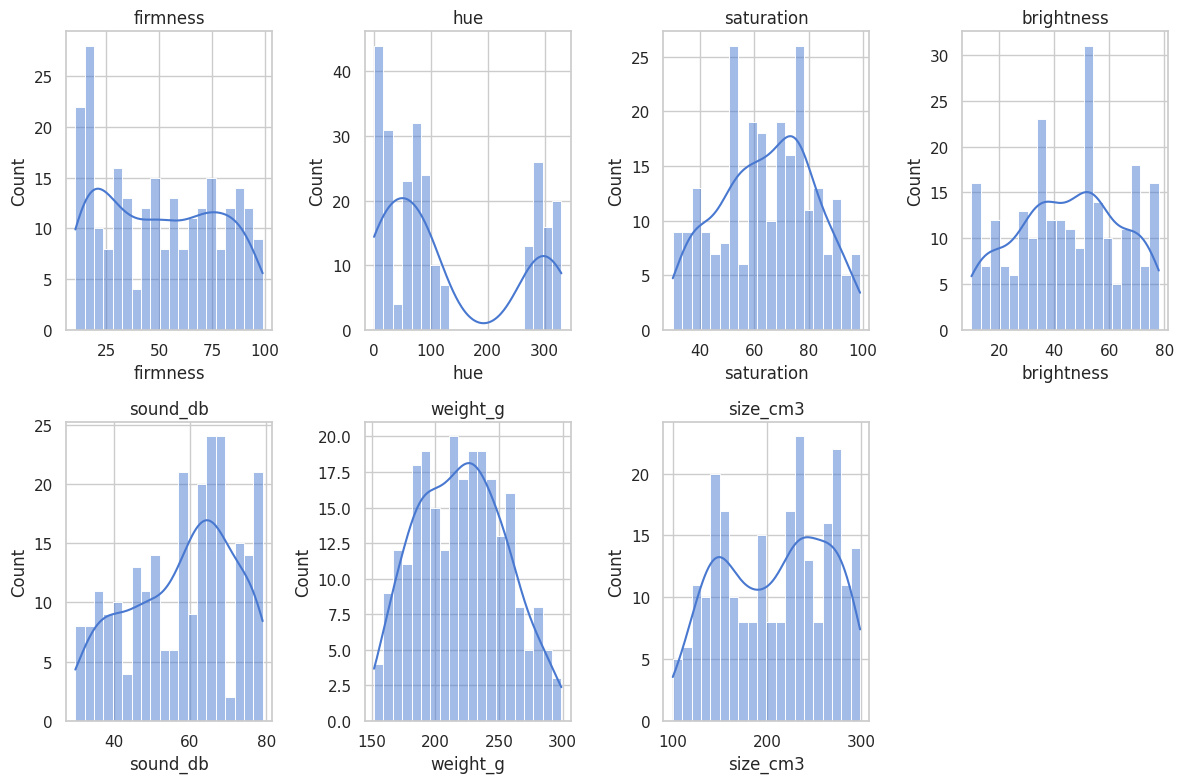

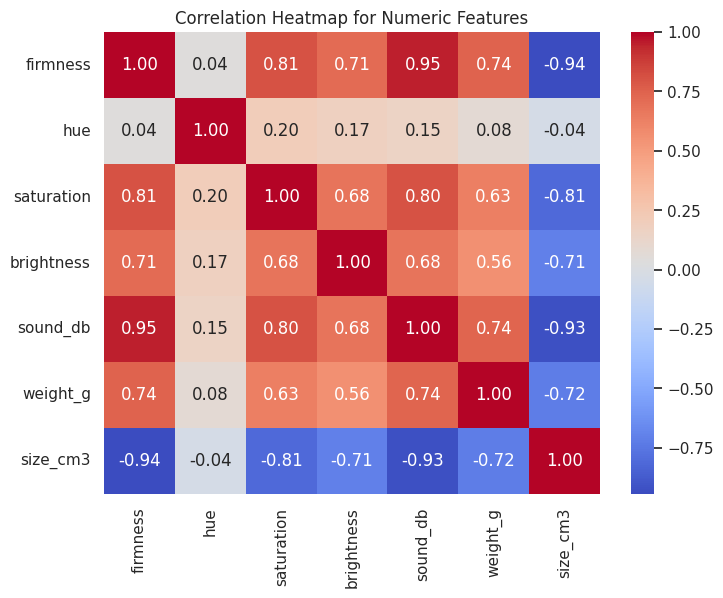

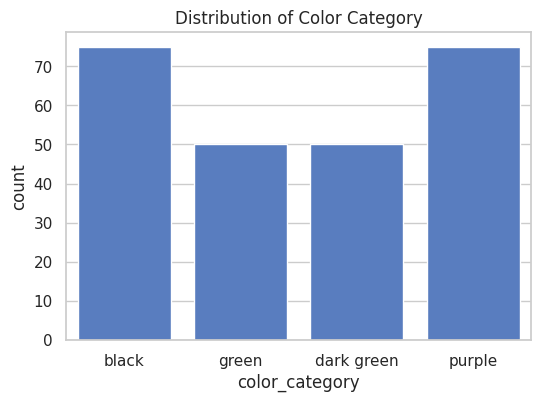

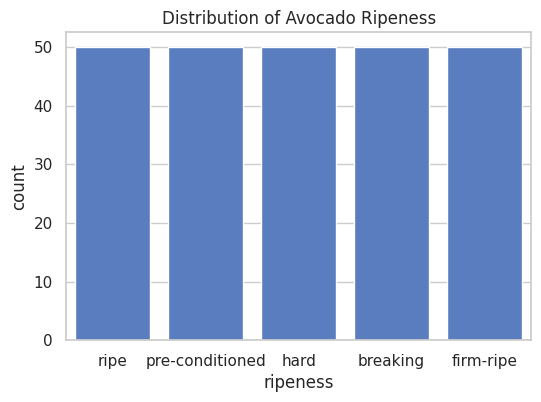

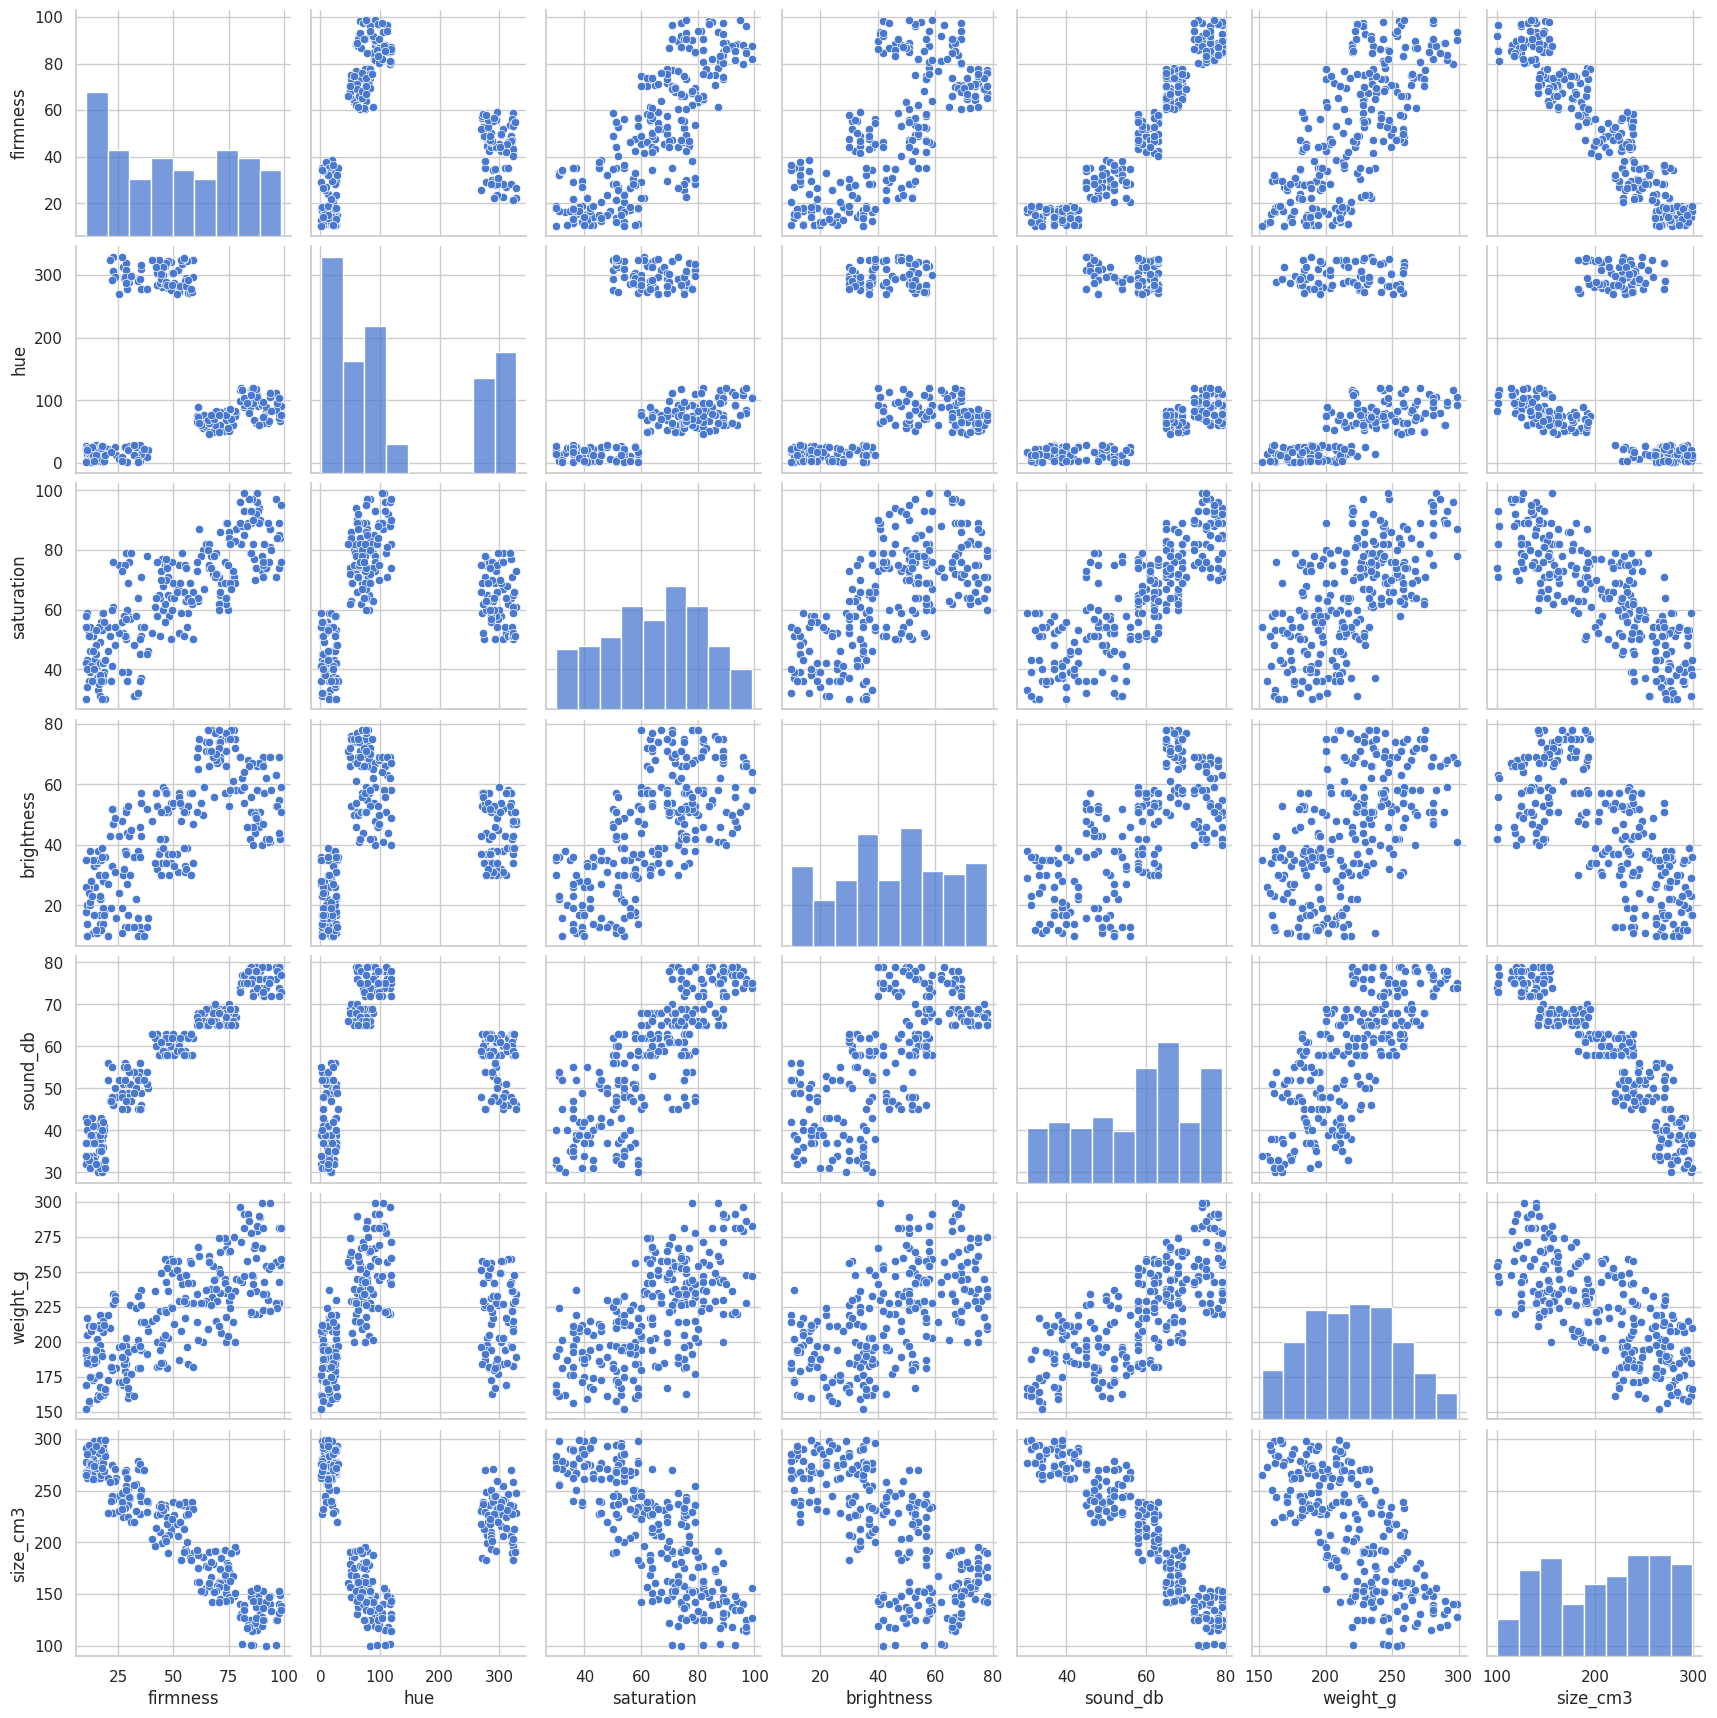

In [10]:
# Identify numeric columns
numeric_df = df.select_dtypes(include=[np.number])
print('Numeric columns:', numeric_df.columns.tolist())

# Plot Histograms for numeric features
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_df.columns, 1):
    plt.subplot(2, (len(numeric_df.columns)+1)//2, i)
    sns.histplot(numeric_df[col], kde=True, bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

# Correlation heatmap if there are at least 4 numeric columns
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap for Numeric Features')
    plt.show()

# Countplot for the categorical feature: color_category
plt.figure(figsize=(6, 4))
sns.countplot(x='color_category', data=df)
plt.title('Distribution of Color Category')
plt.show()

# Countplot for the categorical target: ripeness
plt.figure(figsize=(6, 4))
sns.countplot(x='ripeness', data=df)
plt.title('Distribution of Avocado Ripeness')
plt.show()

# Pairplot to observe relationships among numeric features
sns.pairplot(numeric_df)
plt.show()

## Feature Engineering and Model Preparation
Since our target variable 'ripeness' is categorical with string values and might contain more than two classes, we need to encode it. In addition, any categorical features in the predictors can be encoded as well. In this notebook, we use LabelEncoder for the target variable and proceed with the RandomForestClassifier. We note that when using ROC curves, the binary format is expected. If the classification is multiclass, additional methods such as one-vs-rest could be used. For simplicity, we will conditionally generate a ROC curve only if the problem is binary.

In [11]:
# Encode the target variable: ripeness
le = LabelEncoder()
df['ripeness_encoded'] = le.fit_transform(df['ripeness'])

# If there are additional categorical predictor features, encode them as well
# For this dataset, 'color_category' is categorical and could be one-hot encoded or label encoded.
df['color_category_encoded'] = LabelEncoder().fit_transform(df['color_category'])

# Define features and target
feature_cols = ['firmness', 'hue', 'saturation', 'brightness', 'sound_db', 'weight_g', 'size_cm3', 'color_category_encoded']
X = df[feature_cols]
y = df['ripeness_encoded']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
print('Unique classes:', le.classes_)

Training set shape: (200, 8)
Test set shape: (50, 8)
Unique classes: ['breaking' 'firm-ripe' 'hard' 'pre-conditioned' 'ripe']


## Model Training and Evaluation
We now train a RandomForestClassifier with 100 estimators. After the model is trained, we evaluate the model's performance via accuracy, a confusion matrix, and a classification report.

Regarding the ROC curve, the use of roc_curve from scikit-learn is restricted to binary classification. Since our target may have more than two classes, we include a conditional check. If the problem is binary, we plot the ROC curve; otherwise we print a note indicating that plotting ROC curves for multiclass problems requires a different approach (e.g., one-vs-rest).

Test Accuracy: 1.0

Classification Report:
                 precision    recall  f1-score   support

       breaking       1.00      1.00      1.00        10
      firm-ripe       1.00      1.00      1.00        10
           hard       1.00      1.00      1.00        10
pre-conditioned       1.00      1.00      1.00        10
           ripe       1.00      1.00      1.00        10

       accuracy                           1.00        50
      macro avg       1.00      1.00      1.00        50
   weighted avg       1.00      1.00      1.00        50



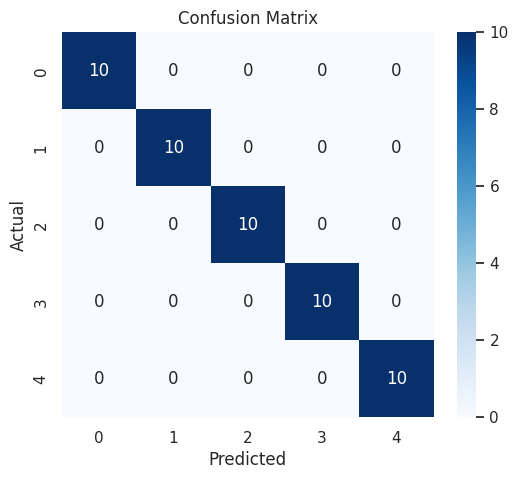

ROC curve is not applicable for multiclass classification. Consider using one-vs-rest strategy for ROC analysis.


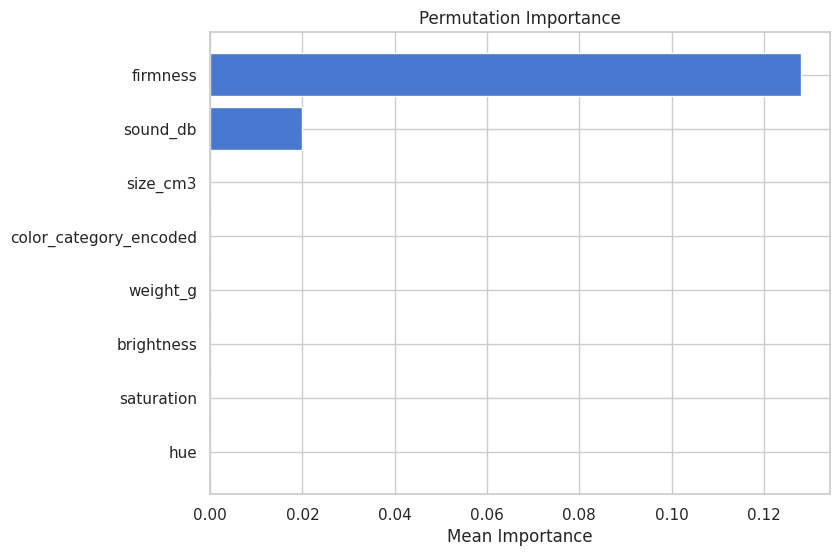

In [12]:
# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)

print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve (only applicable for binary classification)
if len(le.classes_) == 2:
    # Get probability estimates for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
else:
    print('ROC curve is not applicable for multiclass classification. Consider using one-vs-rest strategy for ROC analysis.')

# (Optional) Permutation Importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_cols[i] for i in sorted_idx])
plt.title('Permutation Importance')
plt.xlabel('Mean Importance')
plt.show()

## Conclusion and Future Work
We evaluated various aspects of the avocado ripeness dataset through data cleaning, visualization and model evaluation. The RandomForestClassifier showed promising accuracy. However, care should be taken since a near-perfect accuracy might be indicative of overfitting or an imbalanced dataset.

Future analysis could entail:
- Trying different classification algorithms and performing hyperparameter tuning.- Exploring multiclass ROC analyses (e.g., using one-vs-rest approaches).- Implementing cross-validation and additional feature engineering techniques.
If you found this notebook illuminating, please consider an upvote. Enjoy your data adventures.